# XGBoost Regression

## Setup

In [85]:
from sklearn.model_selection import train_test_split
import pandas as pd
import pyarrow.parquet as pq
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [58]:
df_final = pd.read_parquet(r'C:\Users\ekait\Git\DSC288R_Capstone\data\final\final_data.parquet').dropna()

In [59]:
len(df_final)

20737158

In [60]:
df_final.columns

Index(['FlightDate', 'DayOfWeek', 'Month', 'Airline', 'Origin', 'Dest',
       'Cancelled', 'Diverted', 'DivAirportLandings', 'CRSDepTime', 'DepTime',
       'DepDelay', 'DepDel15', 'CRSArrTime', 'ArrTime', 'ArrDelay', 'ArrDel15',
       'AirTime', 'Distance', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn',
       'DelayCategory', 'AirTimeCategory', 'TimeofDay', 'Origin_PRCP',
       'Origin_SNOW', 'Origin_SNWD', 'Origin_TMAX', 'Origin_TMIN', 'Dest_PRCP',
       'Dest_SNOW', 'Dest_SNWD', 'Dest_TMAX', 'Dest_TMIN'],
      dtype='object')

In [61]:
# Edit DepDelay to have a baseline of 0 (early flights are now considered on-time)
df_final['DepDelay'] = df_final['DepDelay'].clip(lower=0)

In [62]:
# Grab target variables
y = df_final[['DepDelay']]

In [63]:
# Grab explanatory variables
X = df_final[['DayOfWeek', 'Month', 'CRSDepTime', 'CRSArrTime', 'AirTime',
            'Distance', 'Origin_PRCP', 'Origin_SNOW', 'Origin_SNWD', 
            'Origin_TMAX', 'Origin_TMIN', 'Dest_PRCP', 'Dest_SNOW', 
            'Dest_SNWD', 'Dest_TMAX', 'Dest_TMIN']]

In [64]:
# Split into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Plain XGBoost

In [65]:
# Initialize the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)

In [66]:
# Train the model
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [67]:
# Make predictions
y_pred = xgb_reg.predict(X_test)

In [68]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 18.353018799405394
Root Mean Squared Error (RMSE): 45.12210082263203


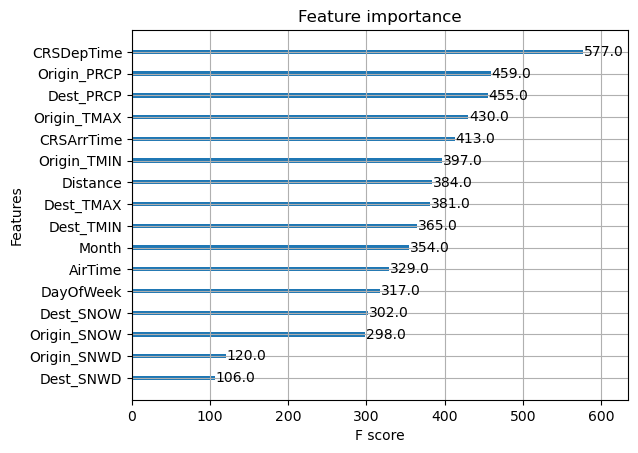

In [69]:
# Plot feature importance
xgb.plot_importance(xgb_reg)
plt.show()

In [70]:
# Baseline model: Predict the mean of y_true for all instances
y_baseline = np.full_like(y_test, fill_value=np.mean(y_train))

# Compute RMSE
rmse_model = mean_absolute_error(y_test, y_pred)
rmse_baseline = mean_absolute_error(y_test, y_baseline)

# Print results
print(f"Your Model's RMSE: {rmse_model:.4f}")
print(f"Baseline RMSE (Mean Predictor): {rmse_baseline:.4f}")
print(f"Improvement over Baseline: {(1 - rmse_model/rmse_baseline) * 100:.2f}%")

Your Model's RMSE: 18.3530
Baseline RMSE (Mean Predictor): 19.5687
Improvement over Baseline: 6.21%


## Log Transformed Target XGBoost

In [71]:
# Initialize the XGBoost Regressor
xgb_reg_logy = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)

In [72]:
y_train_transformed = np.log1p(y_train)  # log(1 + y) to avoid log(0) issues

In [73]:
# Train the model
xgb_reg_logy.fit(X_train, y_train_transformed)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [74]:
y_pred_transformed = xgb_reg_logy.predict(X_test)
y_pred_logy = np.expm1(y_pred_transformed)  # Reverse transformation

In [75]:
mae = mean_absolute_error(y_test, y_pred_logy)
rmse = root_mean_squared_error(y_test, y_pred_logy)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 13.293726063240511
Root Mean Squared Error (RMSE): 47.12019515565492


## MAE focused XGBoost

In [76]:
# Initialize the XGBoost Regressor
xgb_reg_mae = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    eval_metric="mae"
)

In [77]:
# Train the model
xgb_reg_mae.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [78]:
y_pred_mae = xgb_reg_mae.predict(X_test)

In [79]:
mae = mean_absolute_error(y_test, y_pred_mae)
rmse = root_mean_squared_error(y_test, y_pred_mae)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 18.353018799405394
Root Mean Squared Error (RMSE): 45.12210082263203


## MAE + Log XGBoost

In [80]:
# Initialize the XGBoost Regressor
xgb_reg_logy_mae = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    eval_metric="mae"
)

In [81]:
# Train the model
xgb_reg_logy_mae.fit(X_train, y_train_transformed)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [82]:
y_pred_transformed = xgb_reg_logy_mae.predict(X_test)
y_pred_logy_mae = np.expm1(y_pred_transformed)  # Reverse transformation

In [84]:
mae = mean_absolute_error(y_test, y_pred_logy_mae)
rmse = root_mean_squared_error(y_test, y_pred_logy_mae)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 13.293726063240511
Root Mean Squared Error (RMSE): 47.12019515565492


## Residuals

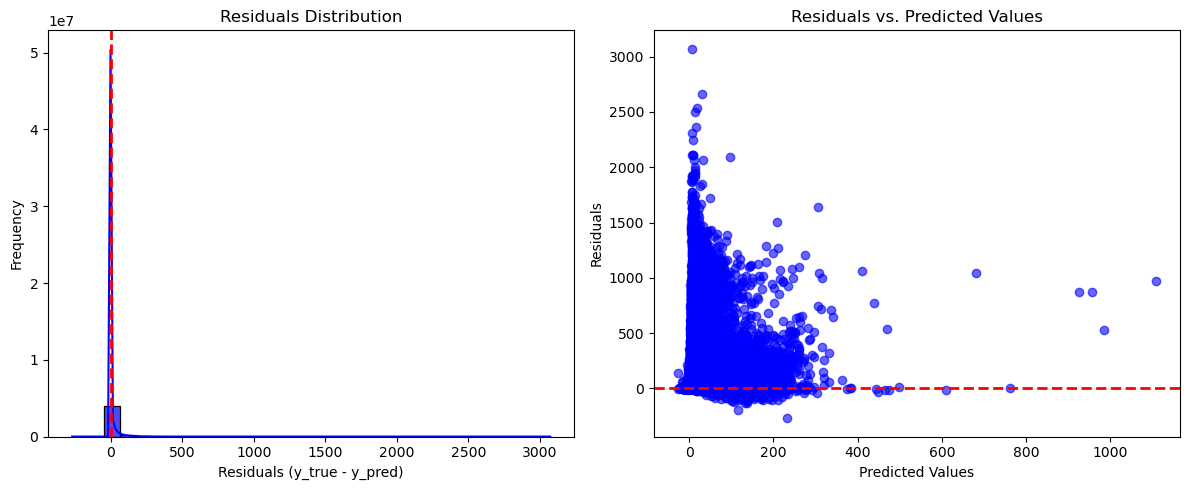

In [96]:
# Compute residuals
residuals = np.array(y_test).flatten() - y_pred_logy_mae

# Plot residuals distribution
plt.figure(figsize=(12, 5))

# Histogram of residuals
plt.subplot(1, 2, 1)
sns.histplot(residuals, bins=30, kde=True, color='blue', alpha=0.7)
plt.axvline(0, color='red', linestyle="dashed", linewidth=2)
plt.xlabel("Residuals (y_true - y_pred)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")

# Residuals vs Predictions scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.6, color='blue')
plt.axhline(0, color='red', linestyle="dashed", linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")

plt.tight_layout()
plt.show()
